## LSTM Method

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
# ----- Seed Setting for Reproducibility -----
seed_value = 250
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# ----- Data Loading and Preprocessing -----
df = pd.read_csv('deep_learning_preprocessed.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Normalize weekday (0-6 scaled to 0-1) to preserve its inherent information
df['weekday_norm'] = df['weekday_num'] / 6.0

# Use a dedicated scaler for cups_sold (the target)
scaler_y = MinMaxScaler(feature_range=(0, 1))
cups_sold_scaled = scaler_y.fit_transform(df[['cups_sold']])

# Combine features: use scaled cups_sold and normalized weekday
# Note: The weekday is already between 0 and 1 and does not need further scaling.
X = np.concatenate([cups_sold_scaled, df[['weekday_norm']].values], axis=1)
y = cups_sold_scaled  # Target is the scaled cups_sold

# ----- Create Time-Series Dataset using a Sliding Window -----
def create_dataset(X, y, window_size):
    X_data, y_data = [], []
    for i in range(len(X) - window_size):
        X_data.append(X[i:i + window_size])
        y_data.append(y[i + window_size])
    return np.array(X_data), np.array(y_data)


In [4]:
window_size = 7
X_data, y_data = create_dataset(X, y, window_size)

# ----- Split Data into Training (80%), Validation (10%), and Test (10%) Sets -----
train_size = int(len(X_data) * 0.8)
val_size = int(len(X_data) * 0.1)
X_train = X_data[:train_size]
y_train = y_data[:train_size]
X_val = X_data[train_size:train_size + val_size]
y_val = y_data[train_size:train_size + val_size]
X_test = X_data[train_size + val_size:]
y_test = y_data[train_size + val_size:]

# ----- Build the LSTM Model -----
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),
    
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.2),
    
    LSTM(128),
    Dropout(0.1),
    
    Dense(1)
])
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse')

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# ----- Define Callbacks -----
# EarlyStopping halts training if validation loss does not improve for 10 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# ReduceLROnPlateau reduces the learning rate if the validation loss plateaus for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# ----- Train the Model -----
history = model.fit(X_train, y_train, epochs=100, batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)

# ----- Evaluate Predictions on the Test Set -----
y_pred_scaled = model.predict(X_test)
# Inverse-transform predictions to get them back to the original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.1442 - val_loss: 0.0879 - learning_rate: 5.0000e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0477 - val_loss: 0.0847 - learning_rate: 5.0000e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0529 - val_loss: 0.0806 - learning_rate: 5.0000e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0617 - val_loss: 0.0772 - learning_rate: 5.0000e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0511 - val_loss: 0.0782 - learning_rate: 5.0000e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0491 - val_loss: 0.0786 - learning_rate: 5.0000e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0399 - val_loss: 0.0762 - learning_rate: 5.0000e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0425 - val_loss: 0.0735 - learning_rate: 5.0000e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0465 - val_loss: 0.0732 - 

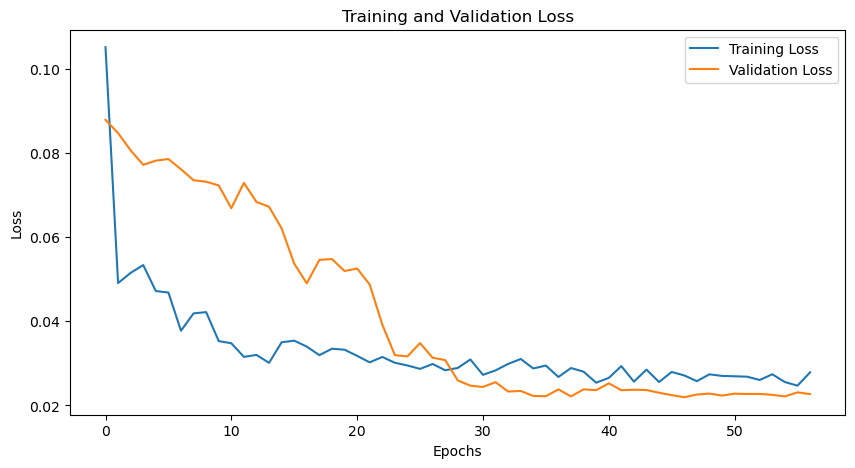

In [6]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [7]:
# ----- Recursive Forecasting Function for Future Predictions -----
def forecast_future(model, last_window, future_weekdays, scaler_y):
    """
    Recursively forecast future cups_sold.
    
    Parameters:
      model: Trained LSTM model.
      last_window: Last observed window (shape: window_size x 2).
      future_weekdays: Iterable of future weekday numbers.
      scaler_y: Scaler for inverse transforming cups_sold.
      
    Returns:
      Array of forecasted cups_sold in the original scale.
    """
    predictions = []
    current_window = last_window.copy()  # shape: (window_size, 2)
    for wd in future_weekdays:
        pred_scaled = model.predict(current_window[np.newaxis, :, :])
        predictions.append(pred_scaled[0, 0])
        # Create new row with the predicted cups_sold (still scaled) and normalized weekday
        new_row = np.array([pred_scaled[0, 0], wd / 6.0])
        # Slide the window: drop the oldest row and append the new prediction row
        current_window = np.vstack([current_window[1:], new_row])
    # Inverse transform predictions to original cups_sold scale
    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    return predictions

In [8]:
# ----- Forecast Future 7 Days (Feb 01, 2025 to Feb 07, 2025) -----
future_dates = pd.date_range(start='2025-02-01', periods=7, freq='D')
future_weekdays = future_dates.weekday  # Monday=0, Tuesday=1, etc.

# Use the last observed window from the dataset as the base for forecasting
last_window = X_data[-1]  # shape: (window_size, 2)

# Get future predictions using the recursive forecasting function
future_preds = forecast_future(model, last_window, future_weekdays, scaler_y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


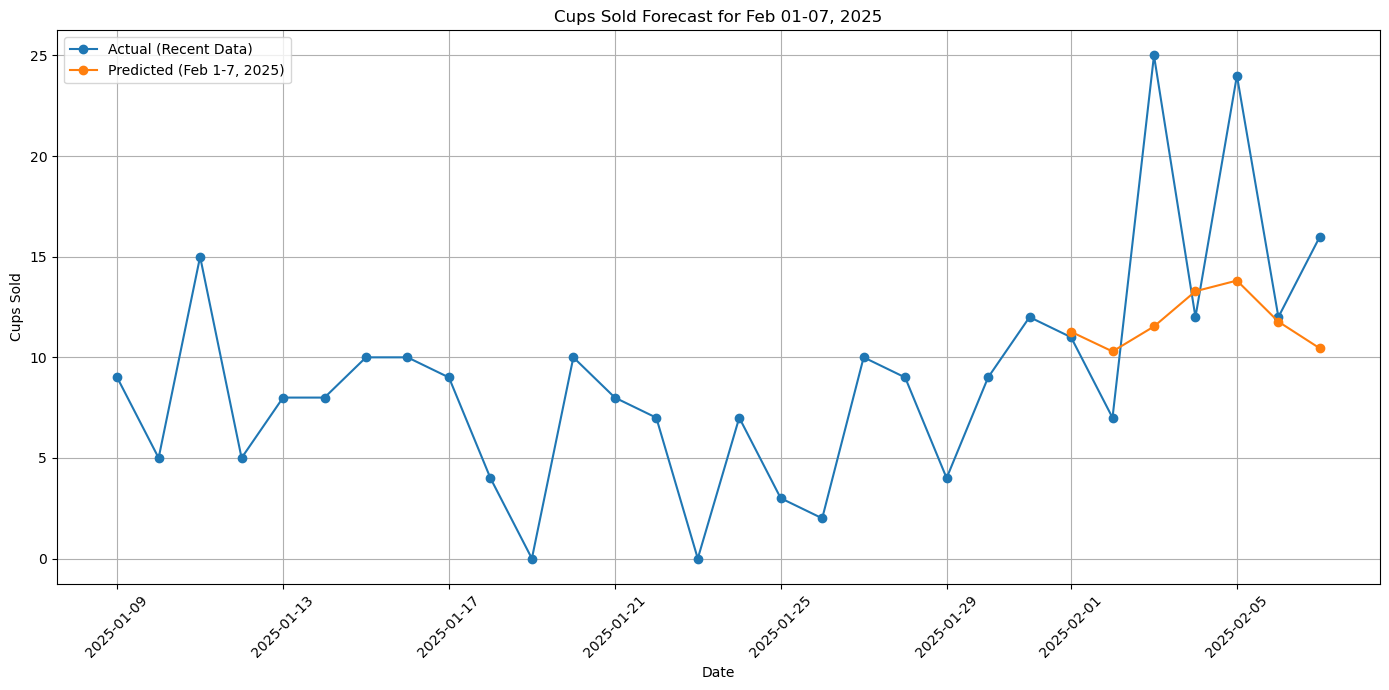

In [9]:
# Plot recent actual cups_sold values and future predictions
plt.figure(figsize=(14, 7))
plt.plot(df['cups_sold'][-30:], label='Actual (Recent Data)', marker='o')
plt.plot(future_dates, future_preds, label='Predicted (Feb 1-7, 2025)', marker='o')
plt.xlabel('Date')
plt.ylabel('Cups Sold')
plt.title('Cups Sold Forecast for Feb 01-07, 2025')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# ----- Calculate Error Metrics -----
# Replace with your actual observed cups_sold for Feb 01-07, 2025
actual_7_days = np.array([11, 7, 25, 12, 24, 12, 26])  # Example actual values

mae = mean_absolute_error(actual_7_days, future_preds)
rmse = np.sqrt(mean_squared_error(actual_7_days, future_preds))
mape = np.mean(np.abs((actual_7_days - future_preds) / actual_7_days)) * 100

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Error (MAE): 6.325765337262835
Root Mean Squared Error (RMSE): 8.780029677144142
Mean Absolute Percentage Error (MAPE): 31.174561098568855
